In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm
import concurrent.futures

print(os.listdir())
import matplotlib.pyplot as plt

['social.txt', 'graph_example625.jpg', 'graph_example425.jpg', 'social_A.txt', 'social_graph_indicator.txt', 'graph_example525.jpg', 'graph_example450.jpg', 'graph_example400.jpg', 'graph_example350.jpg', 'graph_example700.jpg', 'graph_example175.jpg', 'sampling_test.ipynb', 'graph_example225.jpg', 'graph_example75.jpg', 'graph_example650.jpg', 'graph_example550.jpg', 'graph_example600.jpg', 'graph_example50.jpg', 'graph_example725.jpg', 'graph_example300.jpg', 'social_to_adjacency.ipynb', 'graph_example0.jpg', 'graph_example125.jpg', 'graph_example150.jpg', 'graph_example750.jpg', '.ipynb_checkpoints', 'graph_example575.jpg', 'graph_example275.jpg', 'social_node_labels.txt', 'graph_example675.jpg', 'graph_example25.jpg', 'graph_example100.jpg', 'social_graph_labels.txt', 'musae_facebook_edges.csv', 'graph_example475.jpg', 'large_twitch_edges.csv', 'graph_example375.jpg', 'graph_example200.jpg', 'graph_example250.jpg', 'graph_example500.jpg', '.DS_Store', 'artist_edges.csv', 'graph_exa

In [2]:
parent_directory = os.path.dirname(os.getcwd())
data_directory   = os.path.join(parent_directory, "raw_datasets/facebook_large")

In [3]:
filename = "musae_facebook_edges.csv"
dataset_path = os.path.join(data_directory, filename)

social_data = pd.read_csv(dataset_path, delimiter = ",", skiprows = 0)
print(social_data.shape)
# np.savetxt(r'social_A.txt', social_data.values, fmt='%d', delimiter=",\t")
social_data.head()

(171002, 2)


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [4]:
target_filename = "musae_facebook_target.csv"
target_path     = os.path.join(data_directory, target_filename)

target_data = pd.read_csv(target_path, delimiter = ",", skiprows = 0)
target_data.head()

node_ids = target_data["id"].tolist()
page_types = target_data["page_type"].tolist()


unique_page_types = np.unique(page_types)
int_labels = [i for i in range(unique_page_types.shape[0])]

conv_dict = {}
for i, page_type in enumerate(list(unique_page_types)):
    conv_dict[page_type] = int_labels[i]
    
print(conv_dict)

int_labels = {}

for i, item in enumerate(page_types):
    int_labels[str(i)] = conv_dict[item]

{'company': 0, 'government': 1, 'politician': 2, 'tvshow': 3}


In [5]:
import json

attribute_filename = "musae_facebook_features.json"
attribute_path     = os.path.join(data_directory, attribute_filename)

with open(attribute_path, "r") as f:
    attribute_data = json.load(f)
    
attribute_shape = len(attribute_data["15"])
attribute_shape

10

In [6]:
# G = nx.Graph()
# for i in tqdm(range(social_data.shape[0])):
#     G.add_edge(social_data.iloc[i, 0], social_data.iloc[i,1])
# edgelist = [(social_data.iloc[i,0], social_data.iloc[i,1]) for i in tqdm(range(social_data.shape[0]))]
# print(edgelist)

columns = list(social_data.columns)
print(columns)

G = nx.from_pandas_edgelist(social_data, columns[0], columns[1], create_using = nx.Graph)

for node in G.nodes:
    
    G.nodes[node]["target"] = int_labels[str(node)]
    # G.nodes[node]["attribute"] = attribute_data[str(node)]


['id_1', 'id_2']


In [7]:
G = nx.convert_node_labels_to_integers(G)

(171002, 2)
22470
200
80000


  0%|                                                                                                                                                                                                                       | 0/400 [00:00<?, ?it/s]

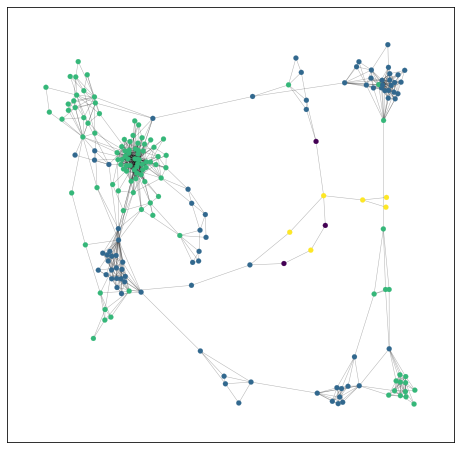

 12%|█████████████████████████▏                                                                                                                                                                                    | 49/400 [00:01<00:07, 49.87it/s]

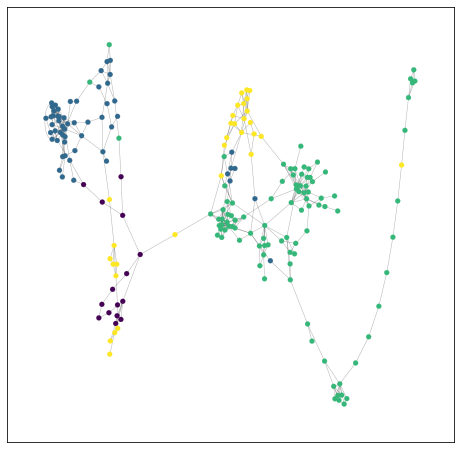

 24%|██████████████████████████████████████████████████▍                                                                                                                                                           | 98/400 [00:02<00:06, 47.11it/s]

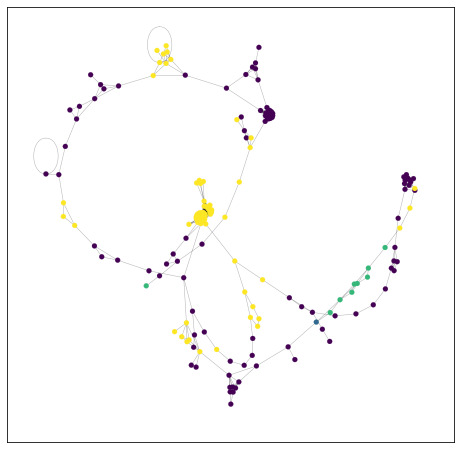

 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 147/400 [00:03<00:05, 47.09it/s]

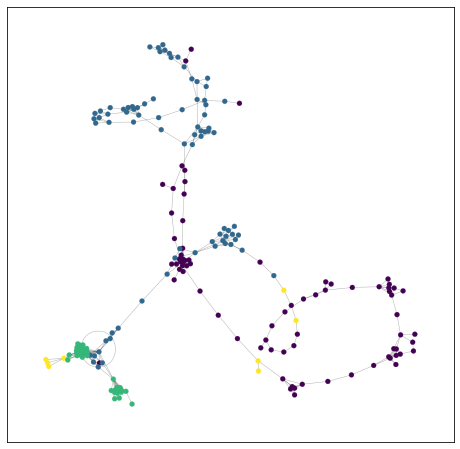

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 196/400 [00:04<00:04, 47.12it/s]

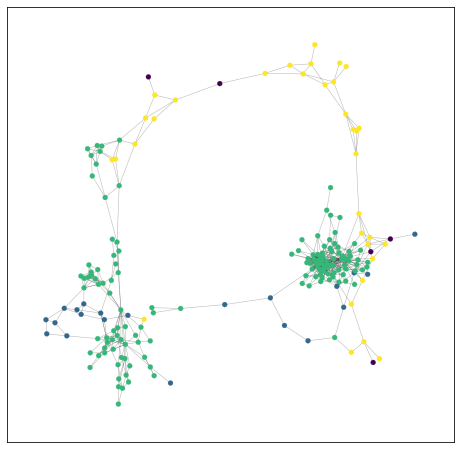

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 248/400 [00:05<00:03, 47.39it/s]

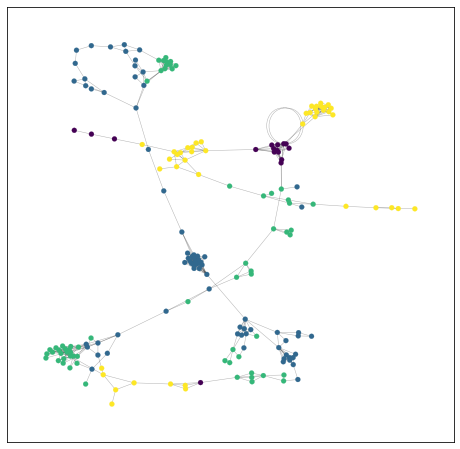

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 299/400 [00:07<00:02, 47.75it/s]

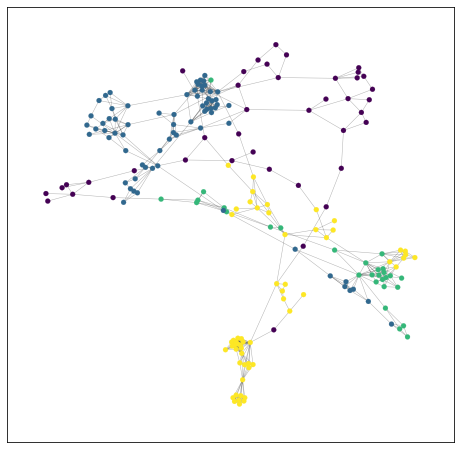

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 349/400 [00:08<00:01, 48.66it/s]

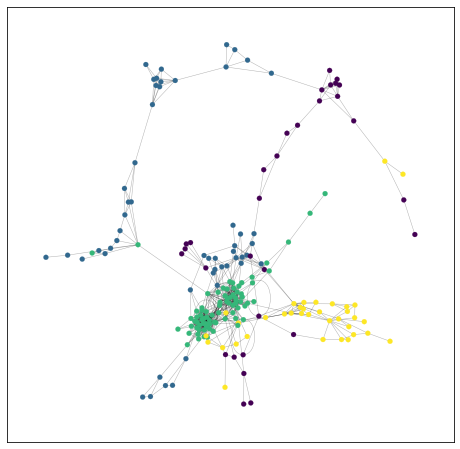

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:09<00:00, 41.87it/s]

(233488, 2)
(79600,)


In [26]:
from littleballoffur import ForestFireSampler, MetropolisHastingsRandomWalkSampler, RandomWalkSampler, DiffusionSampler
print(social_data.shape)
n_nodes = np.unique(social_data.values).shape[0]
print(n_nodes)
n_graphs = 400

graph_ind_array = np.zeros(n_nodes)
min_per_graph = 199
n_per_graph = 200#int(n_nodes / n_graphs)

print(n_per_graph)

total_n = n_per_graph * n_graphs



print(total_n)
graph_ind_array = np.zeros(total_n)


#number_of_nodes = int(0.5*graph.number_of_nodes())


for i in tqdm(range(n_graphs)):
    
    offset_index = i * n_per_graph
    sampler = MetropolisHastingsRandomWalkSampler(number_of_nodes = np.random.randint(min_per_graph, n_per_graph), #n_per_graph,#
                               seed = np.random.randint(1, 1e6))
    new_graph = sampler.sample(G)
    
    # print(len(list(new_graph.nodes())))
    
    new_graph = nx.convert_node_labels_to_integers(new_graph, first_label=offset_index)
    
    graph_ind_array[offset_index:(i+1) * n_per_graph] = i+1
    
    nodes = list(new_graph.nodes())
    
    node_labels_g = [new_graph.nodes[n]["target"] for n in new_graph.nodes]
    
    features = np.zeros((len(nodes), ))
    
    if i ==0:
        graph_adj = np.array(new_graph.edges())
        graph_ind_array = np.array(np.full(len(nodes), i+1))
        node_labels = np.array(node_labels_g)
        
    else:
        graph_adj = np.append(graph_adj, np.array(new_graph.edges()), axis = 0)
        graph_ind_array = np.append(graph_ind_array, np.array(np.full(len(nodes), i+1)))
        node_labels = np.append(node_labels, node_labels_g)
    
    if i % 50 == 0:
        plt.figure(figsize = (8,8))
        
        pos = nx.spring_layout(
          new_graph, k=0.1, iterations=100)
        
        
        colors = []
        
        for g in new_graph.nodes:
            colors.append(new_graph.nodes[g]["target"])
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=25,
          node_color=colors,
          alpha=1,
          linewidths=0.2)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.3, width=0.5)

        plt.savefig(f"graph_example{i}.jpg")
        plt.show()

print(graph_adj.shape)
print(graph_ind_array.shape)

total_n = graph_ind_array.shape[0]

In [27]:
data_dir =        "/home/alex/Projects/GRAN_social/data/FACEBOOK_LARGE/"

# for file in os.listdir(data_dir):
#     print(file)
#     if "DUMMY" in file:
#         shutil.rmtree(f"{data_dir}{file}")

np.savetxt(f'{data_dir}FACEBOOK_LARGE_A.txt', graph_adj, fmt='%d', delimiter=",\t")
np.savetxt(f'{data_dir}FACEBOOK_LARGE_graph_indicator.txt',graph_ind_array, fmt="%d")

np.savetxt(f'{data_dir}FACEBOOK_LARGE_node_labels.txt', node_labels, fmt = "%d")
print(node_labels.shape)

np.savetxt(f'{data_dir}FACEBOOK_LARGE_node_attributes.txt', node_labels, fmt = "%d")
print(node_labels.shape)

np.savetxt(f'{data_dir}FACEBOOK_LARGE_graph_labels.txt', np.ones(total_n), fmt = "%d")
print(np.ones(total_n).shape)


        
# np.savetxt(r'social_A.txt', graph_adj, fmt='%d', delimiter=",\t")
# np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")

# np.savetxt(r'social_node_labels.txt', np.arange(1, total_n+1), fmt = "%d")
# print(np.arange(1, total_n+1).shape)

# np.savetxt(r'social_graph_labels.txt', np.ones(total_n), fmt = "%d")
# print(np.ones(total_n).shape)

(79600,)
(79600,)
(79600,)


In [10]:
# print(social_data.shape)
# n_nodes = np.unique(social_data.values).shape[0]
# print(n_nodes)
# n_graphs = 100

# graph_ind_array = np.zeros(n_nodes)
# n_per_graph = int(n_nodes / n_graphs)

# print(n_per_graph)

# G_ids = []

# for i in range(n_graphs):
    
#     G2 = nx.Graph()

#     for node in G.nodes():
        
#         neighbours = list(G.neighbors(node))


In [11]:


# # for i in range(n_graphs):
    
# #     graph_ind_array[i*n_per_graph : (i+1)*n_per_graph] = i+1
    
# #     if i == n_graphs - 1:
# #         graph_ind_array[(i+1)*n_per_graph:] = i+1

# np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")
# print(graph_ind_array.shape)

In [12]:
# np.savetxt(r'social_node_labels.txt', np.arange(1, n_nodes+1), fmt = "%d")
# print(np.arange(1, n_nodes+1).shape)

In [13]:
# np.savetxt(r'social_graph_labels.txt', np.ones(n_nodes), fmt = "%d")
# print(np.ones(n_nodes).shape)

In [14]:
# adj = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_A.txt", delimiter = ",|\n")
# adj.shape

In [15]:
# g_ind = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_graph_indicator.txt", delimiter = ",|\n")
# g_ind.shape

In [16]:
# n_lab = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_node_labels.txt", delimiter = ",|\n")
# n_lab.shape